In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Data

In [3]:
# Load data

file_path = "/Users/pin.lyu/Documents/BC_Folder/Applied_Project/RainbowTrout_Growth_Data.xlsx"

env_data = pd.read_excel(file_path, sheet_name=1)

fish_data = pd.read_excel(file_path, sheet_name=2)

In [4]:
env_data.head()

,Trip Interval,Discharge,Water Temperature,Solar Insolation,Soluble Reactive Phosphorous Concentration,Rainbow Trout Biomass,HFE,BUG
0,Apr12-Jul12,10.46,9.80,54.28,0.012938,10.350957,0,0
1,Jul12-Sep12,13.62,10.26,49.79,0.010913,11.035601,0,0
2,Sep12-Oct12,8.61,10.53,29.11,0.008508,11.223646,0,0
3,Oct12-Dec12,8.43,9.95,13.84,0.007478,10.732699,1,0
4,Dec12-Jan13,14.73,9.59,10.13,0.007975,13.012068,1,0


In [5]:
fish_data.head()

,Release Trip,Recovery Trip,Release River Mile,Recovery River Mile,Time at Large,Forklength at Release,Forklength at Recapture,Weight at Release,Weight at Recapture,Length_Growth,Weight_Growth
0,2012-04-19,2012-07-05,-4.15,-5.19,77,337.0,334,378.0,331.0,-3.0,-47.0
1,2012-04-19,2012-07-05,-4.15,-4.15,77,330.0,329,322.0,307.0,-1.0,-15.0
2,2012-04-19,2012-07-05,-4.15,-4.15,77,344.0,348,373.0,445.0,4.0,72.0
3,2012-04-19,2012-07-05,-4.15,-4.15,77,284.0,287,198.0,175.0,3.0,-23.0
4,2012-04-19,2012-07-05,-3.73,-3.91,77,93.0,119,6.6,20.0,26.0,13.4


### Data Manipulation

In [7]:
# Calculate Length Growth (Recapture - Release)

fish_data['Length Growth'] = fish_data['Forklength at Recapture'] - fish_data['Forklength at Release']

# Convert Length Growth from mm to cm (overwrites original)

fish_data['Length Growth'] = fish_data['Length Growth'] / 10

In [8]:
# Select variables from env_data to merge with fish_data
env_vars = [
    
    "Discharge", "Water Temperature", "Solar Insolation",
    
    "Soluble Reactive Phosphorous Concentration", 
    
    "Rainbow Trout Biomass", "HFE", "BUG"
]

# 1. Process environmental data - create start/end dates 

## For example, turn April12-July12 to 2012-04-01 and 2012-07-01

def parse_env_dates(interval):
    
    start_part, end_part = interval.split('-')
    
    start_date = pd.to_datetime(start_part + '-01', format='%b%y-%d')
    
    end_date = pd.to_datetime(end_part + '-01', format='%b%y-%d') + relativedelta(months=1, days=-1)
    
    return start_date, end_date

env_data[['start_date', 'end_date']] = env_data['Trip Interval'].apply(parse_env_dates).apply(pd.Series)

# 2. Process fish data

## Ensures fish release/recovery dates are in datetime format for comparison.

fish_data['Release Trip'] = pd.to_datetime(fish_data['Release Trip'])

fish_data['Recovery Trip'] = pd.to_datetime(fish_data['Recovery Trip'])

# 3. Create empty columns for each environmental variable

for var in env_vars:
    
    fish_data[var] = None

# 4. Main matching logic

## Check if the fish's entire tracking period (release → recovery) falls within one environmental interval.

###  When a fish's tracking period spans multiple environmental intervals.  Compute weighted average of environmental values.

for idx, fish_row in fish_data.iterrows():
    
    release = fish_row['Release Trip']
    
    recovery = fish_row['Recovery Trip']
    
    # First try exact interval match
    
    exact_match = env_data[
    
        (env_data['start_date'] <= release) & 
    
        (env_data['end_date'] >= recovery)
    ]
    
    if len(exact_match) == 1:
        
        # Perfect match - use original values
        
        fish_data.loc[idx, env_vars] = exact_match[env_vars].iloc[0].values
        
    else:
        
        # No exact match - use monthly expansion method
        
        # Get all overlapping intervals
        
        overlaps = env_data[
        
            (env_data['end_date'] >= release) & 
        
            (env_data['start_date'] <= recovery)
        
        ]
        
        if len(overlaps) > 0:
            
            # Calculate weighted average based on overlap days
            
            total_days = (recovery - release).days + 1
            
            weights = []
            
            values = []
            
            for _, env_row in overlaps.iterrows():
                
                overlap_start = max(release, env_row['start_date'])
                
                overlap_end = min(recovery, env_row['end_date'])
                
                overlap_days = (overlap_end - overlap_start).days + 1
                
                weight = overlap_days / total_days
                
                weights.append(weight)
                
                values.append(env_row[env_vars])
            
            # Calculate weighted average
            
            weighted_avg = (pd.DataFrame(values) * pd.Series(weights, index=range(len(weights))).values.reshape(-1, 1)).sum()
            
            fish_data.loc[idx, env_vars] = weighted_avg.values

# 5. Verification

print("Verification:")

print(f"Records with exact matches: {len(fish_data[fish_data[env_vars[0]].notna()])}/{len(fish_data)}")

print("\nSample record that should have exact match (first row):")

print(fish_data.loc[0, ['Release Trip', 'Recovery Trip', 'Discharge']])

print("\nOriginal environmental data for Apr12-Jul12:")

print(env_data[env_data['Trip Interval'] == 'Apr12-Jul12'][['Trip Interval', 'Discharge']])

Verification:
Records with exact matches: 9798/9798

Sample record that should have exact match (first row):
Release Trip     2012-04-19 00:00:00
Recovery Trip    2012-07-05 00:00:00
Discharge                      10.46
Name: 0, dtype: object

Original environmental data for Apr12-Jul12:
  Trip Interval  Discharge
0   Apr12-Jul12      10.46


In [9]:
fish_data.head()

,Release Trip,Recovery Trip,Release River Mile,Recovery River Mile,Time at Large,Forklength at Release,Forklength at Recapture,Weight at Release,Weight at Recapture,Length_Growth,Weight_Growth,Length Growth,Discharge,Water Temperature,Solar Insolation,Soluble Reactive Phosphorous Concentration,Rainbow Trout Biomass,HFE,BUG
0,2012-04-19,2012-07-05,-4.15,-5.19,77,337.0,334,378.0,331.0,-3.0,-47.0,-0.3,10.46,9.8,54.28,0.012938,10.350957,0.0,0.0
1,2012-04-19,2012-07-05,-4.15,-4.15,77,330.0,329,322.0,307.0,-1.0,-15.0,-0.1,10.46,9.8,54.28,0.012938,10.350957,0.0,0.0
2,2012-04-19,2012-07-05,-4.15,-4.15,77,344.0,348,373.0,445.0,4.0,72.0,0.4,10.46,9.8,54.28,0.012938,10.350957,0.0,0.0
3,2012-04-19,2012-07-05,-4.15,-4.15,77,284.0,287,198.0,175.0,3.0,-23.0,0.3,10.46,9.8,54.28,0.012938,10.350957,0.0,0.0
4,2012-04-19,2012-07-05,-3.73,-3.91,77,93.0,119,6.6,20.0,26.0,13.4,2.6,10.46,9.8,54.28,0.012938,10.350957,0.0,0.0


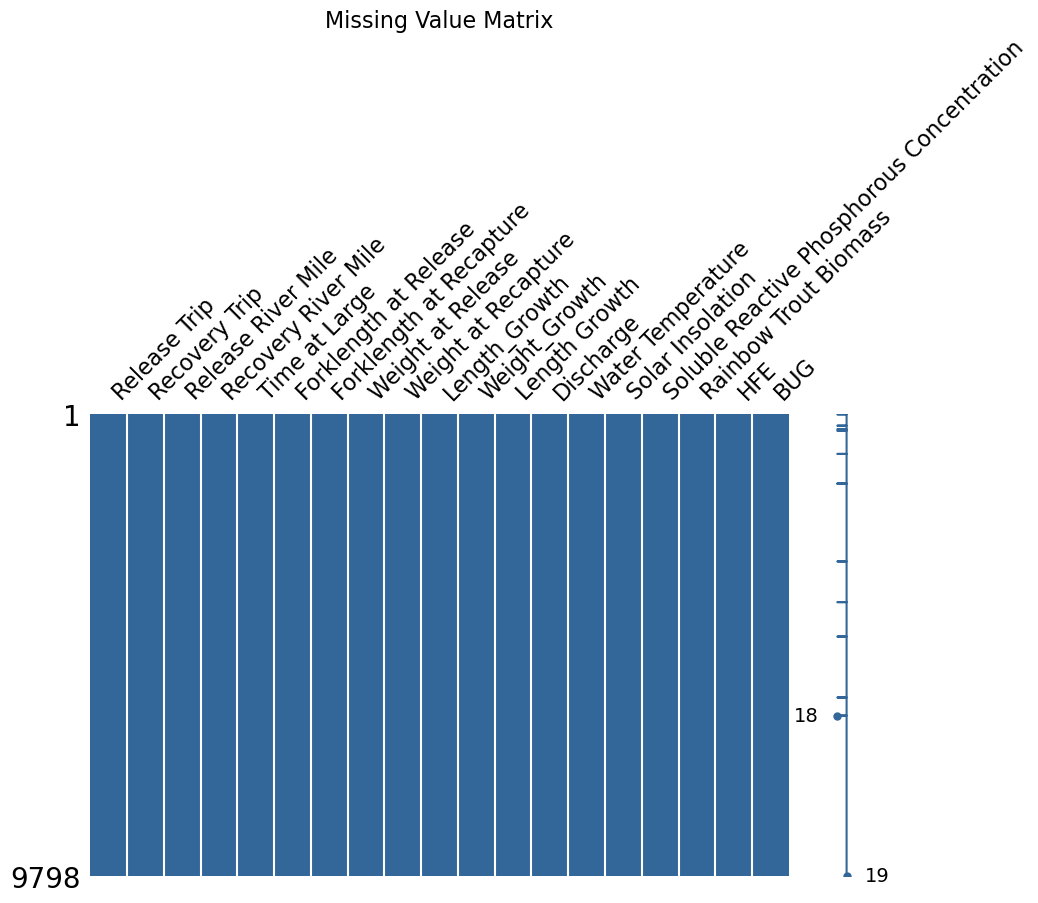

In [10]:
msno.matrix(fish_data, 
            
            figsize=(10, 6),
            
            color=(0.2, 0.4, 0.6))

plt.title("Missing Value Matrix", fontsize=16)

plt.show()

### New Data Frame

In [12]:
# Define the columns you want to keep

selected_columns = [
    
    'Forklength at Release',  
    
    'Time at Large',
    
    'Length Growth',
    
    'Discharge',
    
    'Water Temperature',
    
    'Solar Insolation',
    
    'Rainbow Trout Biomass'
]

# Create new DataFrame

fish_model_data = fish_data[selected_columns]

fish_model_data

,Forklength at Release,Time at Large,Length Growth,Discharge,Water Temperature,Solar Insolation,Rainbow Trout Biomass
0,337.0,77,-0.3,10.46,9.8,54.28,10.350957
1,330.0,77,-0.1,10.46,9.8,54.28,10.350957
2,344.0,77,0.4,10.46,9.8,54.28,10.350957
3,284.0,77,0.3,10.46,9.8,54.28,10.350957
4,93.0,77,2.6,10.46,9.8,54.28,10.350957
...,...,...,...,...,...,...,...
9793,350.0,42,-0.5,9.49,15.44,24.64,6.053751
9794,80.0,42,1.5,9.49,15.44,24.64,6.053751
9795,85.0,42,3.0,9.49,15.44,24.64,6.053751
9796,155.0,42,0.2,9.49,15.44,24.64,6.053751


In [13]:
# Convert Forklength at Release from mm to cm

fish_model_data['Forklength at Release'] = fish_model_data['Forklength at Release'] / 10

/var/folders/0x/ry77ppt564g_7fms7vcmt7nw0000gn/T/ipykernel_40662/4066827037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fish_model_data['Forklength at Release'] = fish_model_data['Forklength at Release'] / 10


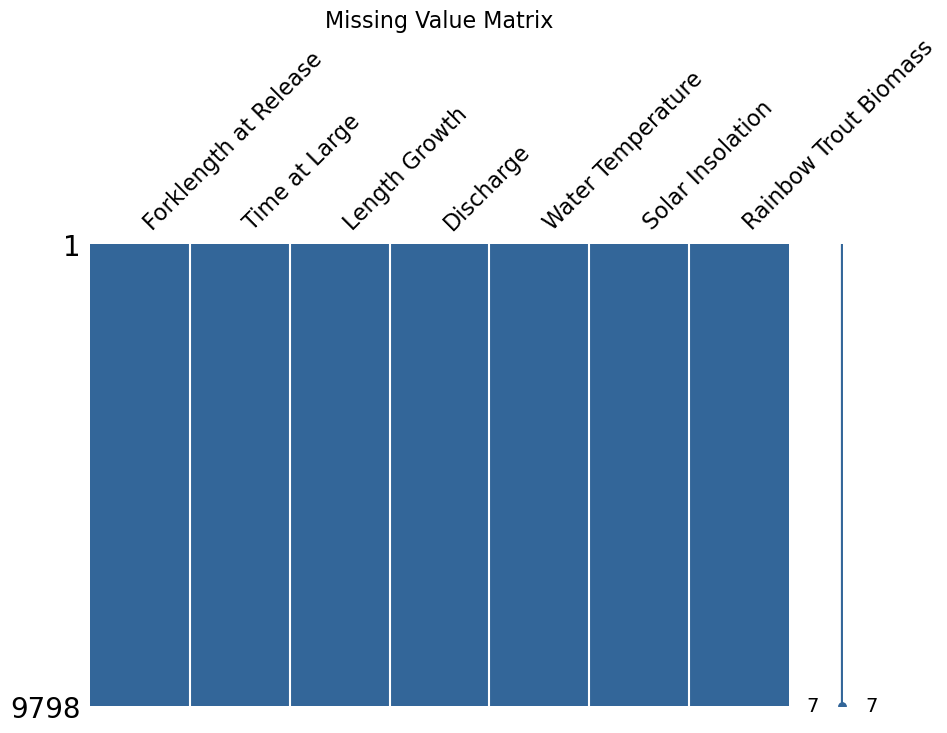

In [14]:
msno.matrix(fish_model_data, 
            
            figsize=(10, 6),
            
            color=(0.2, 0.4, 0.6))

plt.title("Missing Value Matrix", fontsize=16)

plt.show()

In [30]:
fish_model_data.to_csv('fish_model_data.csv', index=False)